# Autoencoders, GANs, and Diffusion Models

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
tf.__version__

'2.19.0'

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


All three are **unsupervised**.

Autoencoders: artificial neural networks capable of learning dense representations of the input data (*latent representations* or *codings*), without any supervision. It can be useful for dimensionality reduction, especially for visualization purposes. It can also be used as feature detectors and for unsupervised pretraining of deep neural networks.

Some autoencoders are also *generative models* where they are capable of randomly generating new data that looks very similar to the training data.

*Generative adversarial networks* (GANs) are neural nets capable of generating data. Widely used for super resolution (increasing the resolution of an image), colorization, image editing, turning simple sketches into photorealistic images, predicting next frames in a video, augmenting dataset, generating other types of data, etc.

*Diffusion models* a generative learning model that can generate more diverse and higher-quality images than GANs, but much slower to run.

Differences
- Autoencoders: learn to copy their inputs to their outputs, aka, the codings are byproducts of the autoencoder learning the identity function under some constraints.
- GANs: composed of 2 neural networks, where both compete against each other during training (*adversarial training*)
    1. *Generator*, tries to generate data that looks similar to the training data
    2. *Discriminator*, tries to tell real data from fake data
- *Denoising diffusion probabilistic model* (DPPM), trained to remove a bit of noise from an image. (if you take an image entirely full of gaussian noise and repeatedly run the diffusion model, a high-quality image will gradually emerge, similar to the training images).

## Efficient Data Representations

Autoencoders looks at the inputs, converts them to an efficient latent representation, and then spits out something that (hopefully) looks very close to the inputs. It is composed of 2 parts
1. *Encoder* (recognition network) converting inputs to a latent representation;
2. *Decoder* (generative network) converting internal representation to the outputs.

Similar to a MLP, but the number of neurons in the output layer MUST EQUAL the number of inputs. The outputs are often called the *reconstructions* (since the autoencoder tries to reconstruct the inputs) and the cost function contains a *reconstruction loss*, which penalizes the model when the reconstructions are different from the inputs.

The autoencoder is said to be *undercomplete* as it has a lower dimensionality than the input data, so it is forced to learn the most important features in the input data.

## Performing PCA with an Undercomplete Linear Autoencoder

Autoencoder with linear activations and MSE cost function will end up performing PCA!

In [8]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer = optimizer)


2025-06-16 18:03:25.493726: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-16 18:03:25.493751: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-16 18:03:25.493758: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1750068205.493772 7448079 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750068205.493792 7448079 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# extra code – builds the same 3D dataset as in Chapter 8

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [10]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2025-06-16 18:03:25.755784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1750068205.763976 7448079 meta_optimizer.cc:967] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


2/2 [==============================] - 0s 5ms/step


In [11]:
codings.shape

(60, 2)

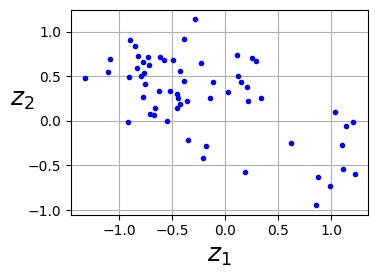

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

Think of autoencoder as performing a form of self-supervised learning, as it is based on a supervised learning technique with automaticlaly generated labels.

## Stacked Autoencoders

Autoencoders with multiple hidden layers (basic autoencoder only has 1 hidden layer, which is the encoder part).

The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (coding layer), aka looks like a sandwich.

### Implementation Using Keras

In [8]:
import tensorflow as tf
import numpy as np

# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0340 - val_loss: 0.0185
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0176 - val_loss: 0.0167
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 12/20
1719/1719 ━━━━━━━━

### Visualizing the Reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


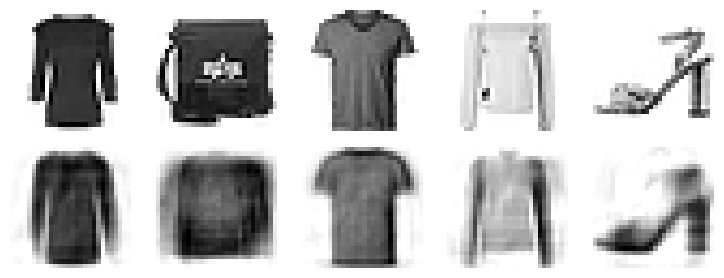

In [10]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")

        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
    
plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

### Visualizing the Fashion MNUST Dataset

Since autoencoders can handle large datasets with many instances and features, one strategy is to use an autoencoder to reduce the dimensionality to a reasonable level, then use another dimensionality reduction algorithm for visualization.

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_decoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid,
            s=10, cmap="tab10")
plt.show()

In [ ]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

### Unsupervised Pretraining Using Sstacked Autoencoders

When there is a large dataset but most of it is unlabeled, we can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for the actual task and train it using the labeled data.

### Tying Weights

A common technique is to tie the weights of the decoder layers to the weights of the encoder layers, which lead to halving the number of weights in the model and can speed up training and limiting the risk of overfitting.

In [16]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)
    
    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [ ]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, ctivation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

In [ ]:
# extra code – plots reconstructions
plot_reconstructions(tied_ae)
plt.show()

### Training One Autoencoder at a Time

Also called "greedy layerwise training"

1. Create an autoencoder that learns to reconstruct the inputs, then encode the whole training set as a new data set.
2. Train a second autoencoder on this new dataset
3. Create a big sandwich using all the autoencoders from 1 and 2.


In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None, learning_rate=1e-3):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    autoencoder.compile(loss="mse", optimizer=optimizer)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, learning_rate=5e-4)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu",
    learning_rate=5e-3)

In [ ]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

In [ ]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [ ]:
stacked_ae_1_by_1.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

In [ ]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders

The encoder is a regular CNN composed of convolutional layers and pooling layers. It reduces the spatial dimensionality of the inputs, while increasing the depth (number of feature maps).

The decoder will do the reverse, upscale the image and reduce the depth back to the original dimensions. This can be done by transposing the convolutional layers (or combine upsampling layers with convolutional layers.)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

## Extra Material - Recurrent Autoencoders


In [ ]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())

In [ ]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
plot_reconstructions(recurrent_ae)
plt.show()

## Denoising Autoencoders

Anothe way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. These are called *stacked denoising autoencoders*.

The implementation is through a regular stacked autoencoder with an additional `Dropout` layer applied to the encoder's inputs (or you could use a `GaussianNoise` layer instead).

In [18]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 31s 17ms/step - loss: 0.0440 - val_loss: 0.0379
Epoch 2/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0682 - val_loss: 0.0437
Epoch 3/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.1071 - val_loss: 0.0503
Epoch 4/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.1667 - val_loss: 0.0644
Epoch 5/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3410 - val_loss: 0.0894
Epoch 6/10
1719/1719 [==============================] - 28s 16ms/step - loss: 0.5964 - val_loss: 0.0386
Epoch 7/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.7871 - val_loss: 1.3894
Epoch 8/10
1719/1719 [==============================] - 29s 17ms/step - loss: 1.2709 - val_loss: 0.0629
Epoch 9/10
1719/1719 [==============================] - 29s 17ms/step - loss: 1.9198 - val_loss: 0.1303
Epoch 10/10
1719/1719 [==============================] - 27s 16m

1/1 [==============================] - 0s 51ms/step


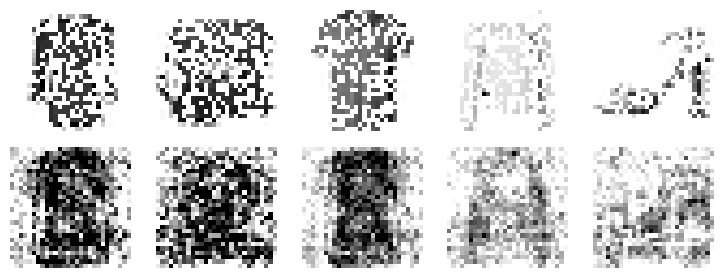

In [19]:
# extra code – this cell generates and saves Figure 17–9
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

If you want, you can try replacing the `Dropout` layer with `tf.keras.layers.GaussianNoise(0.2)`.

## Sparse Autoencoders

By adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations, as a result each neuron in the coding layer typically ends up representing a useful feature.

We can achieve this by using the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer, and add some $l_1$ regularization to the coding layer's activations.

Using l1 norm, rather than l2 norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# extra code – compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_l1_ae)
plt.show()

Another approach is to measure the actual sparsity of the coding layer at each training iteration, and penalize the model when the measured sparsity differs from a target sparsity. This is done by computing the average activation of each neuron in the coding layer, over the whole training batch.

Once we have the mean activation per neuron, we can penalize the neurons that are too active (or not active enough) by adding a *sparsity loss* to the cost function.

Below is a sample curve for the sparsity loss, the recommended approach is to use the Kullback-Leibler (KL) divergence, which has much stronger gradients than the MSE!

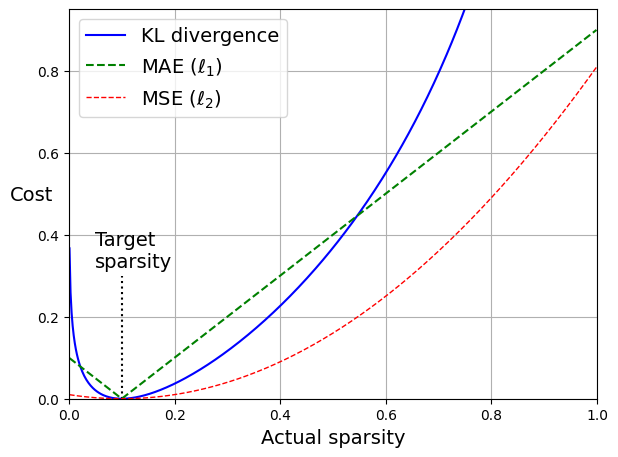

In [20]:
# extra code – this cell generates and saves Figure 17–10
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

Let's define a custom regularizer for KL-Divergence regularization:

In [ ]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# extra code – compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_kl_ae)
plt.show()

## Variational Autoencoders (VAEs)

They are different from all the autoencoders above by:
- Being a *probabilistic autoencoder*, meaning that their outputs are partly determined by chance, even after training
- *generative autoencoders*, meaning that they can generate new instances that look like they were sampled from the training set.

VAEs perform variational Bayesian inference, which is an efficient way of carrying out approximate Bayesian inference (recall that it means to update a probability distribution based on new data, using equations derived from Bayes' theorem).

Start with a basic autoencoder (containing both an encoder and decoder), but instaed of directly producing a coding for a given input, the encoder produces a *mean coding* $μ$ and a standard deviation $σ$.

The actual coding is then sampled randomly from a Gaussian distribution with mean *μ* and standard deviation *σ*. After that the decoder decodes the sample coding normally. 

The cost function is composed of 2 parts:
1. Reconstruction loss that pushes the autoencoder to reproduce its inputs.
2. *Latent loss* that pushes the autoencoder to have codings that look as though they were sample from a simple Gaussian distribution (KL divergence between the target distribution and the actual distribution of the codings).

First make a custom layer to sample the codings

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

**Encoder**

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

**Decoder**

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

**Variational Autoencoder**

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [ ]:
variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

In [ ]:
plot_reconstructions(variational_ae)
plt.show()

## Generating Fashion MNIST Images

In [21]:
X_train[0].shape

(28, 28)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [ ]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

Now let's perform semantic interpolation between 2 images:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

In [ ]:
# extra code – this cell generates and saves Figure 17–13
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()

## Generative Adversarial Networks

Composed of 2 neural networks:
1. *Generator*, takes a random distribution as input (typically Gaussian) and outputs some data, typically an image. Offers the same functionality as a decoder in a variational autoencoder.
2. *Discriminator*, takes either a fake image from the generator or a real image from the training set as input, and must guess whether the input image is fake or real.

Training then happens in 2 phases:
1. Train the discriminator, where a batch of real images is sampled from the training set and is completed with an equal number of fake images produced by the generator. In this phase, backpropagation only optimizes the weights of the discriminator during this phase.
2. Train the generator, use it to produce another batch of fake images, then have the discriminator to tell whether the images are fake or real. This time, we do not add real images in the batch, and labels images to 1 (real), on other words we want the generator to produce images that the discriminator will (wrongly) believe to be real. Backpropagation only affects the weights of the generator in this phase.

In [ ]:
codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid"),
])

gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

**Need to write a custom training loop**

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # phase 1 - trainining the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - traiing the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

### The Difficulties of Training GANs

GANs can only reach a single Nash equilibrium, when the generator producs perfectly realistic images, and the discriminator is forced to guess (50% real, 50% fake). Nonetheless, there is nothing that guarantess that the equilibrium will ever be reached.

This is due to *mode collapse*: when the generator's outputs gradually become less diverse and gradually cycle across a few classes, never really becoming very good at any of them.

Also, since the generator and discriminator are constantly pushing against each other, their parameters may end up oscillating and become unstable, so it is very sensitive to hyperparameters and need a lot of effort fine-tuning them.

    One method to overcome this is by *experience replay* where we store the images produced by the generator at each iteration in a replay  bufer (gradually dropping older generated images) and training the discriminator using real images + fake images drawn from this buffer.

    Another is *mini-batch discrimination*, where we measure how similar images are across the batch and provide this statistic to the discriminator so it can easily reject a batch of fake images that lack diversity!

### Deep Convolutional GANs

The guidelines are:
- Replace any poolig layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator)
- Use batch normalization in both the generator and discriminator, except in the generator's output layer and discriminator's input layer
- Remove fully connected hidden layers for deeper architectures
- Use ReLU activation in the generator for all layers except the output layer, which should use tanh
- Use leaky ReLU activation in the discriminator for all layers.

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
# extra code – compiles the discrimator and the gan, as earlier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
# note that in this case X_train's values have been normalized!
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
# extra code – generates the dataset and trains the GAN, just like earlier
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

In [ ]:
# extra code – this cell generates and saves Figure 17–16
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

If you add each iamge's class as an extra input to both the generator and discriminator, they will both learn what each class looks like, and thus will be able to contorl the class of each image produce by the generator. This is called a *conditional GAN* (CGAN).

### Progressive Growing of GANs

### StyleGANs

used *style transfer* techniques in the generator to ensure that the generated images have the same local structure as the training images, at every scale, greatly improving the quality of the generated images.

A StyleGAN generator is composed of 2 networks
1. *Mapping Network*, mapping the latent representation **z** (codings) to a vector **w**. This vector is then sent through multiple *affine transformation* (`Dense` layers with no activation functions), which produces multiple vectors. These vectors control the style of the generated images at different levels.
2. *Synthesis network*, responsible for generating the images. It processes input through multiple convolutional and upsampling layers with 2 twist
    1. Some noise is added to the input and to all the outputs of the convolutional layers (before the activation function)
    2. Each noise layer is followed by an *adaptive instance normalization* (AdaIN) layer, where it standardizes each feature map independently, then uses the style vector to determine the scale and offset of each feature map.

The reason for adding noise independently is important because of
- If the noise comes from the codings, it meant that the generator had to dedicate a significant portion of the codings' representational power to store noise;
- This noise will also have to flow through the network and reach the final layers of the generator, which seems like an unnecessary constraing and probably slowed down training;
- Some visual artifacts may appear because the same noise was used at different levels so if the generator tried to do it, it would lead to even more visual artifacts;
- Some parts of the generator's weight would be dedicated to generate this pseudorandom noise, which seems wasteful;

Finally, StyleGAN also uses a technique called *mixing regularization*, where a percentage of the generate d images are produced using 2 diffferent codings. Specifically the codings c1 and c2 are sent through the mapping network, giving 2 style vectors w1 and w2. Then the synthesis network generates an image based on the styles w1 for the first levels and the styles w2 for the remaining level, where the cutoff level is picked randomly. This helps in preventing the network from assuming that styles at adjacent levels are correlated, which could encourage locality in the GAN and having each style vector only affecting a limited number of traits in the generated image.

## Diffusion Models

Core idea is to train a model to learn the reverse process: start from a completely mixed state, and gradually "unmix" milk and tea from a mix of milk and tea.

*Denoising Diffusion Probabilistic Model* (DDPM), 
1. *forward process*: suppose you start with a picture of a cat and at each time step we add a little bit of Gaussian noise to the image (the noise is independent for each pixel, aka isotropic). After certain time t, the cat is completely hidden by the noise. 
2. *reverse process*: training a model that can remove a tiny bit of noise from an image, and repeat the operation many times until all the noise is gone, which will gradually make a brand new cat appear!

In [25]:
def variance_schedule (T, s = 0.008, max_beta = 0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1+s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:]/ f[:-1], 1-max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta

T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

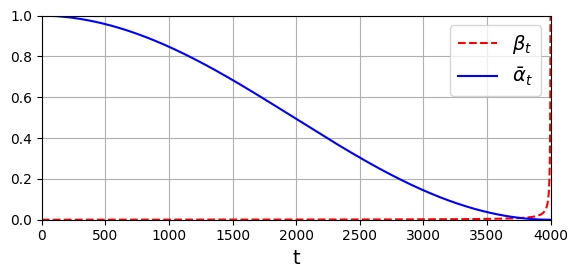

In [26]:
# extra code – this cell generates and saves Figure 17–21
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
save_fig("variance_schedule_plot")
plt.show()

The `prepare_batch()` function takes a batch of images and adds noise to each of them, using a different random time between 1 and $T$ for each image, and it returns a tuple containing the inputs and the targets:

* The inputs are a `dict` containing the noisy images and the corresponding times. The function uses equation (4) from the DDPM paper to compute the noisy images in one shot, directly from the original images. It's a shortcut for the forward diffusion process.
* The target is the noise that was used to produce the noisy images.

In [28]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

Note that the target is the `noise`, while the input is the dictionary containing the noisy image and the time step used to generate them.

Now let's prepare a `tf.data.Dataset` for training, and one for validation.

In [29]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # extra code – ensures reproducibility on CPU
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

As a quick sanity check, let's take a look at a few training samples, along with the corresponding noise to predict, and the original images (which we get by subtracting the appropriately scaled noise from the appropriately scaled noisy image):

In [ ]:
# extra code – just a quick sanity check

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

Now we're ready to build the diffusion model itself. It will need to process both images and times. We will encode the times using a sinusoidal encoding, as suggested in the DDPM paper, just like in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. Given a vector of _m_ integers representing time indices (integers), the layer returns an _m_ × _d_ matrix, where _d_ is the chosen embedding size.

In [ ]:
# extra code – implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

Now let's build the model. In the Improved DDPM paper, they use a UNet model. We'll create a UNet-like model, that processes the image through `Conv2D` + `BatchNormalization` layers and skip connections, gradually downsampling the image (using `MaxPooling` layers with `strides=2`), then growing it back again (using `Upsampling2D` layers). Skip connections are also added across the downsampling part and the upsampling part. We also add the time encodings to the output of each block, after passing them through a `Dense` layer to resize them to the right dimension.

* **Note**: an image's time encoding is added to every pixel in the image, along the last axis (channels). So the number of units in the `Conv2D` layer must correspond to the embedding size, and we must reshape the `time_enc` tensor to add the width and height dimensions.
* This UNet implementation was inspired by keras.io's [image segmentation example](https://keras.io/examples/vision/oxford_pets_image_segmentation/), as well as from the [official diffusion models implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py). Compared to the first implementation, I added a few things, especially time encodings and skip connections across down/up parts. Compared to the second implementation, I removed a few things, especially the attention layers. It seemed like overkill for Fashion MNIST, but feel free to add them.

In [ ]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Nadam())

# extra code – adds a ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=100,
                    callbacks=[checkpoint_cb])  # extra code

Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time $T$. Then we use the model to predict the image at time $T - 1$, then we call it again to get $T - 2$, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset. The equation for this reverse process is at the top of page 4 in the DDPM paper (step 4 in algorithm 2).

In [ ]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
X_gen = generate(model)  # generated images

In [ ]:
plot_multiple_images(X_gen.numpy(), 8)
save_fig("ddpm_generated_images_plot")
plt.show()

 Some of these images are really convincing! Compared to GANs, diffusion models tend to generate more diverse images, and they have surpassed GANs in image quality. Moreover, training is much more stable. However, generating images takes *much* longer.

There are also *latent diffusion models*, where the diffusion process takes place in latent space (rather than pixel space). This is achieved through using a powerful autoencoder to compress each training image into a much smaller latent space, where the diffusion process takes place, then the autoencoder is used to decompress the final latent representation, generating the output image.

# Exercise

13. Go through KerasCV's Stable Diffusion tutorial to generate a drawing of a salamander reading a book!